In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import mrvi
import scvi
import anndata

%load_ext autoreload
%autoreload 2

Global seed set to 0
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['axes.facecolor'] = (1, 1, 1, 0)

In [3]:
covariate_key = 'sample'
condition_key = covariate_key
cell_type_key = ['predicted.celltype.l1']
adata = sc.read(
    '../../../lataq_reproduce_backup/lataq_reproduce/data/su_2020_rna.h5ad'
)
fred_full_meta = pd.read_csv('/lustre/groups/ml01/workspace/hediyehzadeh.s/shared_data/multigrate_multimil/notebooks/covid19_datasets_metadata_fredhutch.csv', index_col = 0)

datasetkey = 'su_2020'
fred_meta = fred_full_meta[fred_full_meta.dataset == datasetkey]
adata.obs = fred_meta

KeyboardInterrupt: 

In [4]:
adata_tmp = adata.copy()
sc.pp.normalize_total(adata_tmp)
sc.pp.log1p(adata_tmp)
sc.pp.highly_variable_genes(
    adata_tmp, n_top_genes=2000, flavor="seurat", subset=False
)
adata = adata[:, adata_tmp.var['highly_variable']]

In [5]:
adata.obs['dummy'] = 'dummy'

/tmp/ipykernel_2310854/2754918074.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dummy'] = 'dummy'
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [ ]:
# Sample (e.g. donors, perturbations, etc.) should go in sample_key
# Sites, plates, and other factors should go in categorical_nuisance_keys
adata = adata.copy()
mrvi.MrVI.setup_anndata(adata, sample_key="sample")
mrvi_model = mrvi.MrVI(adata)
mrvi_model.train()

In [48]:
mrvi_model.save('./mrvi', overwrite=True)

In [6]:
# Sample (e.g. donors, perturbations, etc.) should go in sample_key
# Sites, plates, and other factors should go in categorical_nuisance_keys
adata = adata.copy()
mrvi.MrVI.setup_anndata(adata, sample_key="sample", categorical_nuisance_keys=["dummy"])
mrvi_model = mrvi.MrVI.load('./mrvi', adata)


INFO     File ./mrvi/model.pt already downloaded                                                                   


In [ ]:
mrvi_embeddings = mrvi_model.module.sample_embeddings.weight.cpu().detach().numpy()
index_ = (
    mrvi_model._adata.obs.drop_duplicates("_scvi_sample")
    .set_index("_scvi_sample")
    .sort_index()
    .loc[:, 'sample']
)
mrvi_embeddings = pd.DataFrame(mrvi_embeddings, index=index_)

In [ ]:
mrvi_adata = sc.AnnData(X=mrvi_embeddings.values)
mrvi_adata.obs_names = mrvi_embeddings.index
mrvi_adata.obs = adata.obs.groupby('sample').first().reindex(mrvi_embeddings.index)

In [ ]:
mrvi_adata.obsm['X_pca'] = mrvi_adata.X

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mrvi_adata.obs['disease_severity'] = mrvi_adata.obs['disease_severity'].astype(str)
mrvi_adata.obs['disease_severity'][mrvi_adata.obs['disease_severity'] == 'nan'] = 'healthy'
sc.pl.pca(mrvi_adata, color='disease_severity', frameon=False, show=False, ax=ax)
ax.set_title('Disease severity')

In [13]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
cv = KFold(n_splits=5, shuffle=True, random_state=42)
i = 1
df_list = []
mrvi_adata.obs['disease_severity'] = mrvi_adata.obs['disease_severity'].astype(str)
mrvi_adata.obs['disease_severity'][mrvi_adata.obs['disease_severity'].isna()] = 'healthy'
mrvi_adata.obs['disease_severity'] = mrvi_adata.obs['disease_severity'].astype('category')
#adata_mean = adata_mean[adata_mean.obs['disease_severity']!='healthy']
for train_samples, _ in cv.split(mrvi_adata.obs.index.unique()):
    sample_ref = mrvi_adata.obs.index.unique()[train_samples]
    mrvi_adata.obs['batch'] = '0'
    mrvi_adata.obs['batch'][~mrvi_adata.obs.index.isin(sample_ref)] = '1'
    X_train = mrvi_adata[mrvi_adata.obs['batch']=='0'].obsm['X_pca']
    X_test = mrvi_adata[mrvi_adata.obs['batch']=='1'].obsm['X_pca']
    y_train = mrvi_adata.obs['disease_severity'][mrvi_adata.obs['batch']=='0'].values
    y_test = mrvi_adata.obs['disease_severity'][mrvi_adata.obs['batch']=='1'].values
    clf = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    df_list.append(pd.DataFrame(classification_report(y_test, y_pred, target_names=clf.classes_, output_dict=True)))

/tmp/ipykernel_135221/3283015230.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrvi_adata.obs['disease_severity'][mrvi_adata.obs['disease_severity'].isna()] = 'healthy'
/tmp/ipykernel_135221/3283015230.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrvi_adata.obs['batch'][~mrvi_adata.obs.index.isin(sample_ref)] = '1'
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

In [14]:
df_mrvi = pd.concat(df_list)

In [15]:
df_mrvi = df_mrvi.loc['f1-score']

In [49]:
df_mrvi.to_csv('mrvi_accuracy.csv')

In [50]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, batch_key="sample")
scvi_model = scvi.model.SCVI(adata)
scvi_model.train()
# Get z representation
adata.obsm["X_scvi_z"] = scvi_model.get_latent_representation()

/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=14 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14/14: 100%|███████████| 14/14 [08:15<00:00, 35.50s/it, loss=201, v_num=1]

`Trainer.fit` stopped: `max_epochs=14` reached.


Epoch 14/14: 100%|███████████| 14/14 [08:15<00:00, 35.40s/it, loss=201, v_num=1]


In [62]:
scvi_model.save('scvi')

In [51]:
adata_scvi = scvi_model.get_latent_representation()

In [52]:
adata_scvi = sc.AnnData(X=adata_scvi, obs=adata.obs)

In [53]:
adata_scvi.obs['sample'] = adata_scvi.obs['sample'].astype('category')

In [54]:
res = pd.DataFrame(columns=adata_scvi.var_names, index=adata_scvi.obs['sample'].cat.categories)                                                                                                 

for clust in adata_scvi.obs['sample'].cat.categories: 
    res.loc[clust] = adata_scvi[adata_scvi.obs['sample'].isin([clust]),:].X.mean(0)
    
adata_mean = sc.AnnData(res.values)
adata_mean.obs = adata_scvi.obs.groupby('sample').first()

/tmp/ipykernel_171940/3023072655.py:6: FutureWarning: X.dtype being converted to np.float32 from object. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_mean = sc.AnnData(res.values)
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['1-1', '1-2', '10-1', '10-2', '100-1']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [55]:
sc.pp.pca(adata_mean)

In [57]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
cv = KFold(n_splits=5, shuffle=True, random_state=42)
i = 1
df_list = []
adata_mean.obs['disease_severity'] = adata_mean.obs['disease_severity'].astype(str)
adata_mean.obs['disease_severity'][adata_mean.obs['disease_severity'].isna()] = 'healthy'
adata_mean.obs['disease_severity'] = adata_mean.obs['disease_severity'].astype('category')
#adata_mean = adata_mean[adata_mean.obs['disease_severity']!='healthy']
for train_samples, _ in cv.split(adata_mean.obs.index.unique()):
    sample_ref = adata_mean.obs.index.unique()[train_samples]
    adata_mean.obs['batch'] = '0'
    adata_mean.obs['batch'][~adata_mean.obs.index.isin(sample_ref)] = '1'
    sc.pp.pca(adata_mean)
    X_train = adata_mean[adata_mean.obs['batch']=='0'].obsm['X_pca']
    X_test = adata_mean[adata_mean.obs['batch']=='1'].obsm['X_pca']
    y_train = adata_mean.obs['disease_severity'][adata_mean.obs['batch']=='0'].values
    y_test = adata_mean.obs['disease_severity'][adata_mean.obs['batch']=='1'].values
    clf = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    df_list.append(pd.DataFrame(classification_report(y_test, y_pred, target_names=clf.classes_, output_dict=True)))

/tmp/ipykernel_171940/734593382.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_mean.obs['disease_severity'][adata_mean.obs['disease_severity'].isna()] = 'healthy'
/tmp/ipykernel_171940/734593382.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_mean.obs['batch'][~adata_mean.obs.index.isin(sample_ref)] = '1'
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [58]:
df_mean = pd.concat(df_list)

In [59]:
df_mean = df_mean.loc['f1-score']

In [60]:
df_mean

,mild,moderate,nan,severe,accuracy,macro avg,weighted avg
f1-score,0.765957,0.604651,0.00,0.266667,0.611111,0.409319,0.558967
f1-score,0.807692,0.555556,0.00,0.000000,0.574074,0.340812,0.514245
f1-score,0.697674,0.634146,0.00,0.380952,0.592593,0.428193,0.570881
f1-score,0.781250,0.615385,0.25,0.400000,0.666667,0.511659,0.632870
f1-score,0.851064,0.619048,0.80,0.285714,0.685185,0.638956,0.662843


<AxesSubplot: >

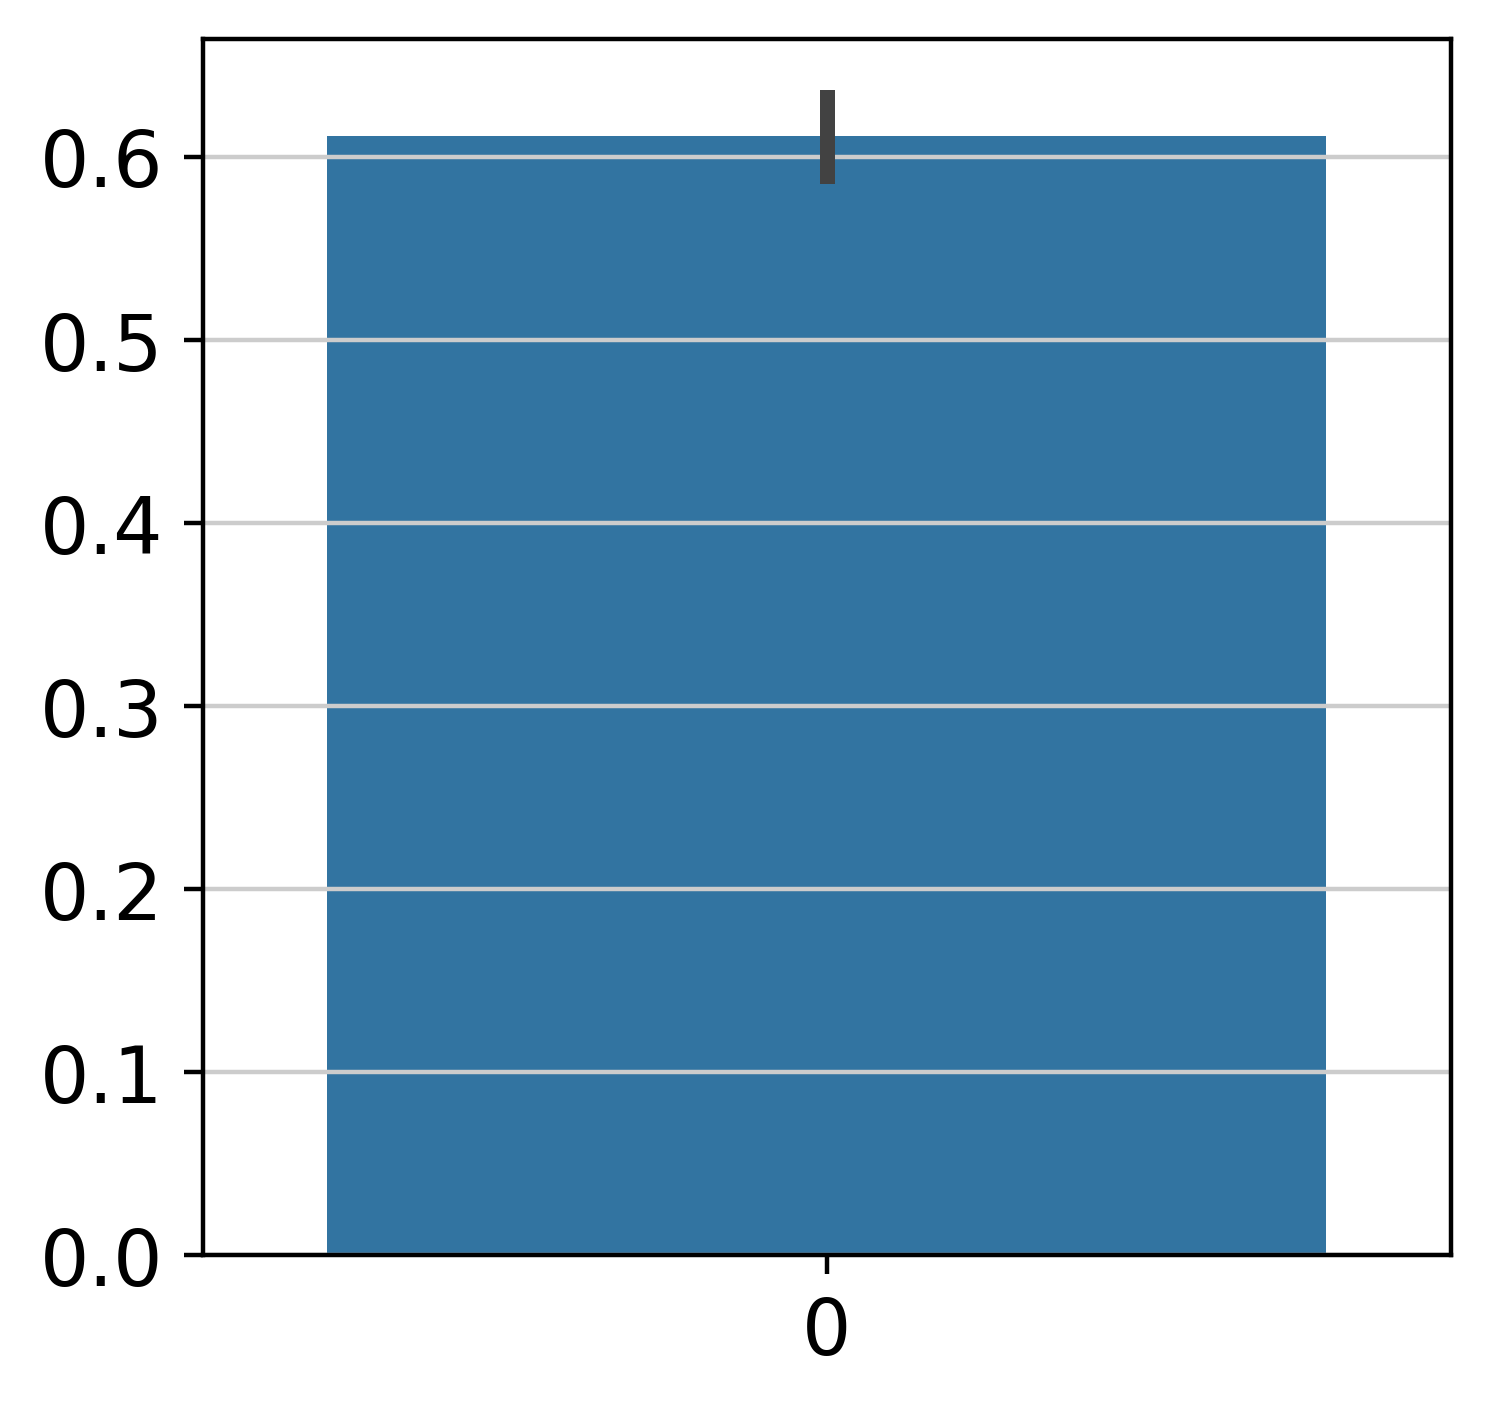

In [61]:
sns.barplot(df_mean['accuracy'], estimator=np.median, errorbar='se')

In [4]:
df_mean.to_csv('scvi_accuracy.csv')

NameError: name 'df_mean' is not defined

In [5]:
df_scpoli = pd.read_csv('scpoli_accuracy.csv', index_col=0)
df_scvi = pd.read_csv('scvi_accuracy.csv', index_col=0).assign(model='scVI')
df_mrvi = pd.read_csv('mrvi_accuracy.csv', index_col=0).assign(model='mrVI')

In [7]:
df_full = pd.concat([df_scpoli, df_scvi, df_mrvi])

In [8]:
df_full.groupby('model').mean()

,mild,moderate,severe,accuracy,macro avg,weighted avg,healthy,nan
model,,,,,,,,
meanGE,0.814344,0.575621,0.298095,0.618519,0.458682,0.592804,0.146667,NaN
mrVI,0.442294,0.181012,0.128271,0.303704,0.187894,0.268070,NaN,0.00
scPoli,0.812894,0.623807,0.347854,0.672441,0.594852,0.652568,NaN,NaN
scVI,0.780728,0.605757,0.266667,0.625926,0.465788,0.587961,NaN,0.21


In [9]:
0.009/0.672

0.01339285714285714

<AxesSubplot: xlabel='model', ylabel='weighted avg'>

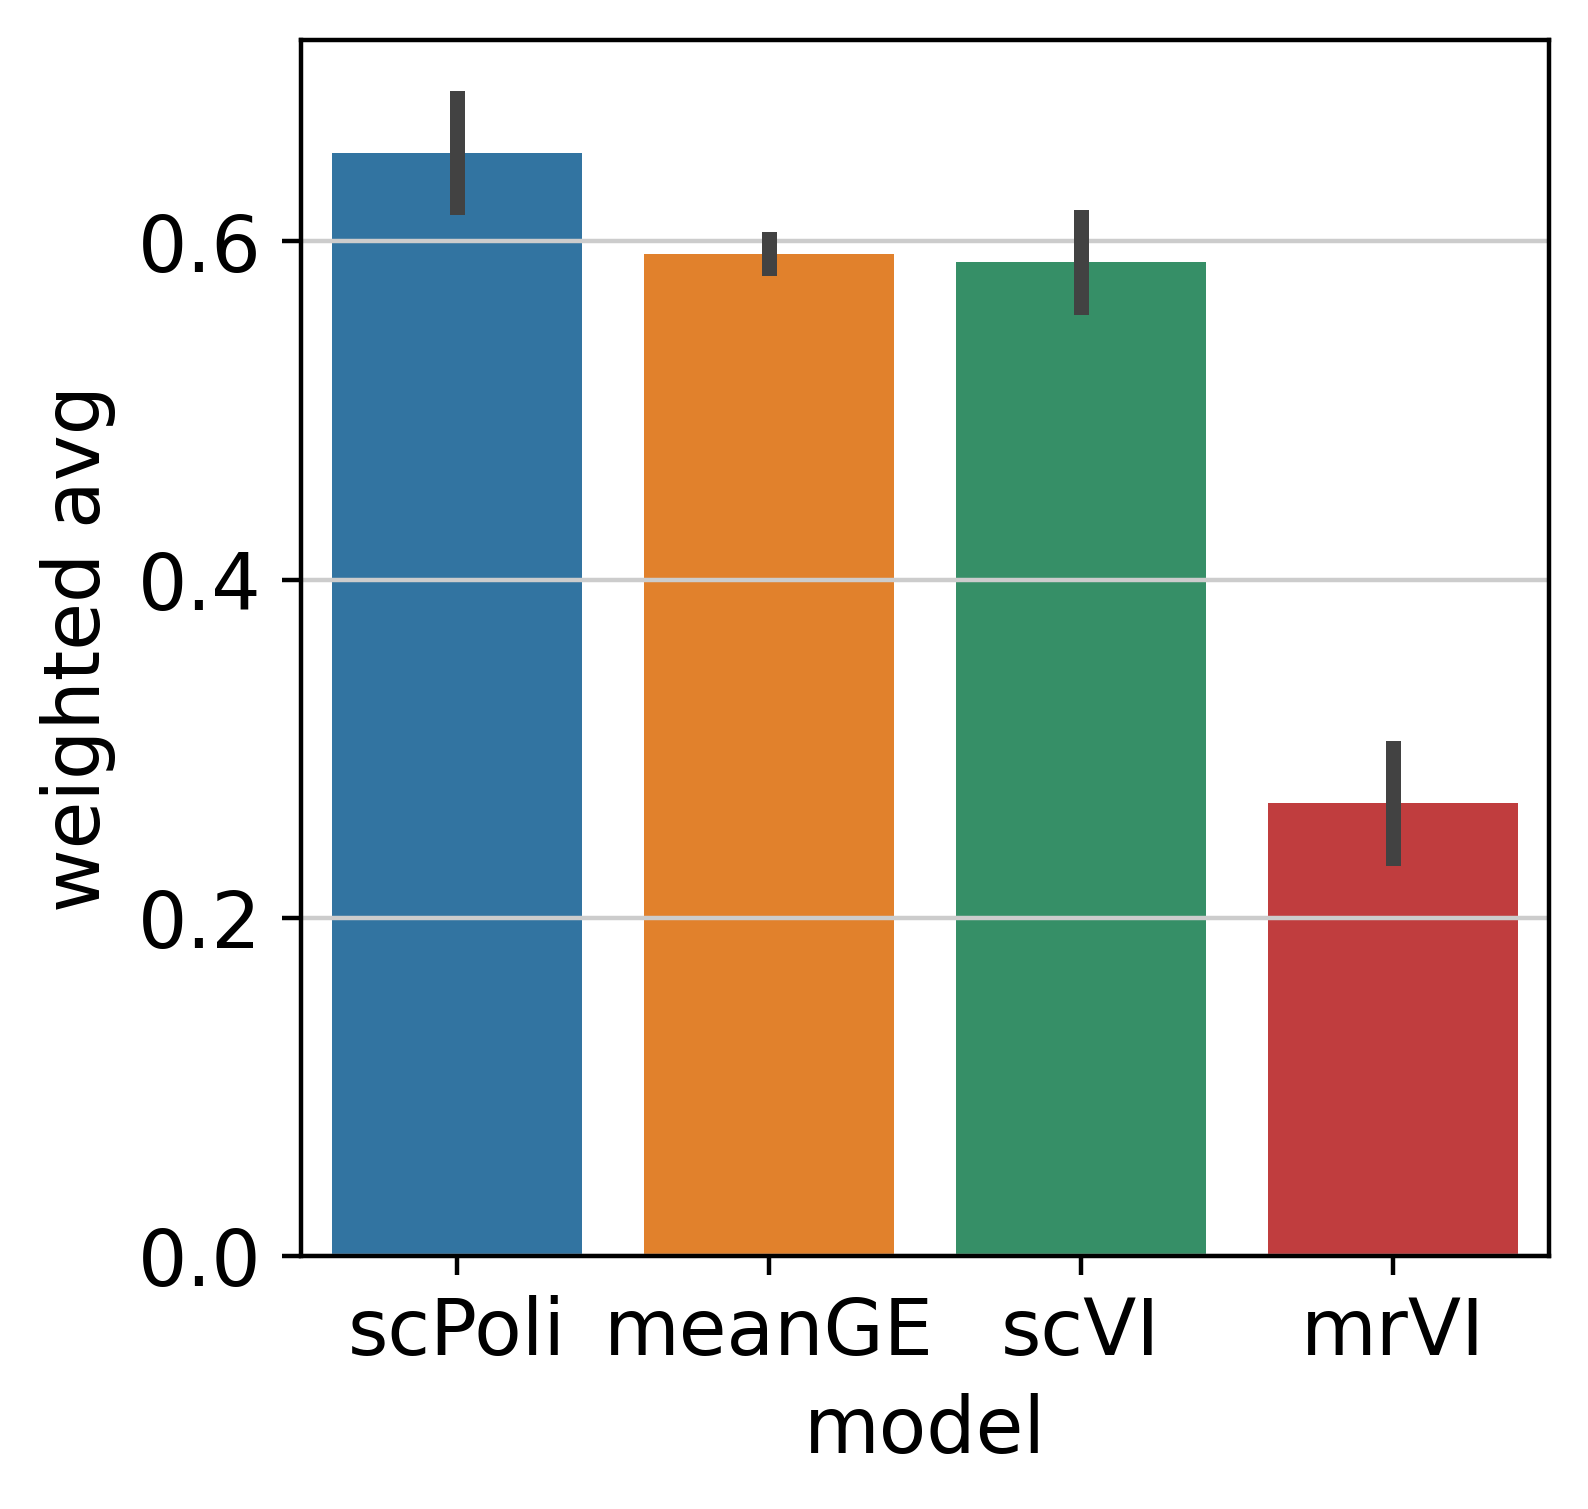

In [10]:
sns.barplot(x='model', y='weighted avg', data=df_full, estimator=np.mean, errorbar='se')

In [11]:
df_full = df_full[df_full['model'].isin(['scPoli', 'meanGE', 'scVI'])]
df_full['model'] = df_full['model'].astype('category')
df_full['model'] = df_full['model'].cat.reorder_categories(['scPoli', 'scVI', 'meanGE'])

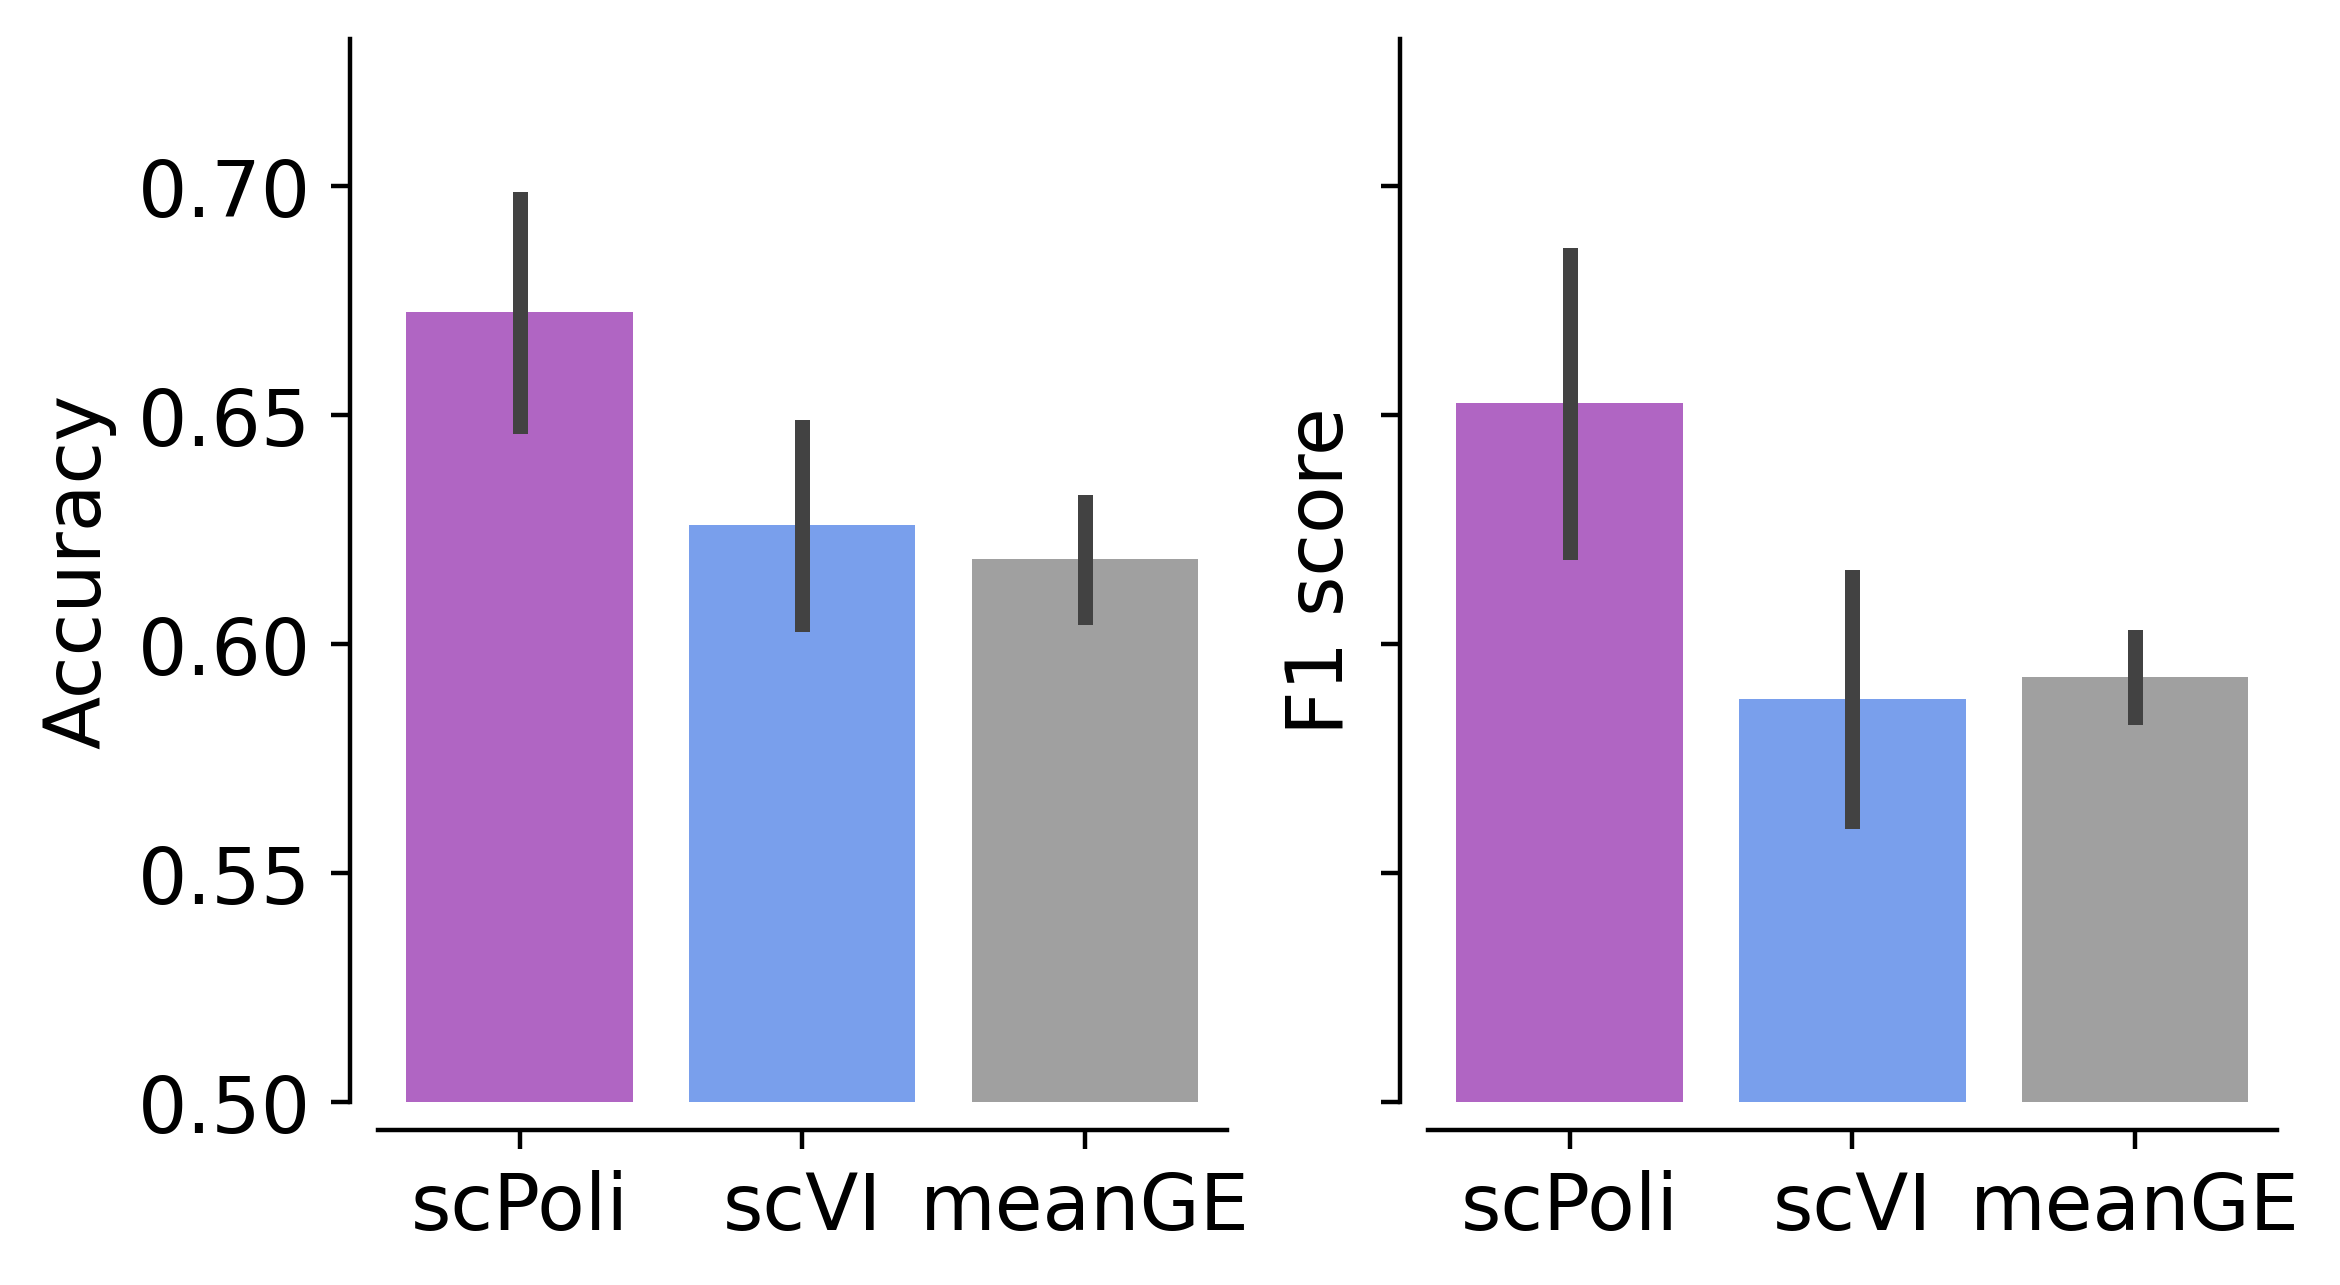

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
sns.barplot(
    x='model', 
    y='accuracy', 
    data=df_full, 
    estimator=np.mean, 
    errorbar='se', 
    ax=ax[0],
    palette=['#BA55D3', '#6699ff', '#A0A0A0'],
)
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[0])
ax[0].set_ylim(bottom=0.5)
l = ax[0].get_xticklabels()
ax[0].grid(False)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('')
ax[0].set_xticklabels(l, rotation=90)
sns.barplot(
    x='model', 
    y='weighted avg', 
    data=df_full, 
    estimator=np.mean, 
    errorbar='se', 
    ax=ax[1],
    palette=['#BA55D3', '#6699ff', '#A0A0A0'],
)
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[1])
l = ax[1].get_xticklabels()
ax[1].set_ylim(bottom=0.5)
ax[1].grid(False)
ax[1].set_ylabel('F1 score')
ax[1].set_xlabel('')
fig.tight_layout()
sns.despine(offset=5)
ax[0].set_xticklabels(l, rotation=0)
ax[1].set_xticklabels(l, rotation=0)
fig.savefig('classification_performance.png', dpi=400, bbox_inches='tight')

In [ ]:
df_full = df_full[df_full['model'].isin(['scPoli', 'meanGE', 'scVI', 'mrVI'])]
df_full['model'] = df_full['model'].astype('category')
df_full['model'] = df_full['model'].cat.reorder_categories(['scPoli', 'scVI', 'mrVI', 'meanGE'])

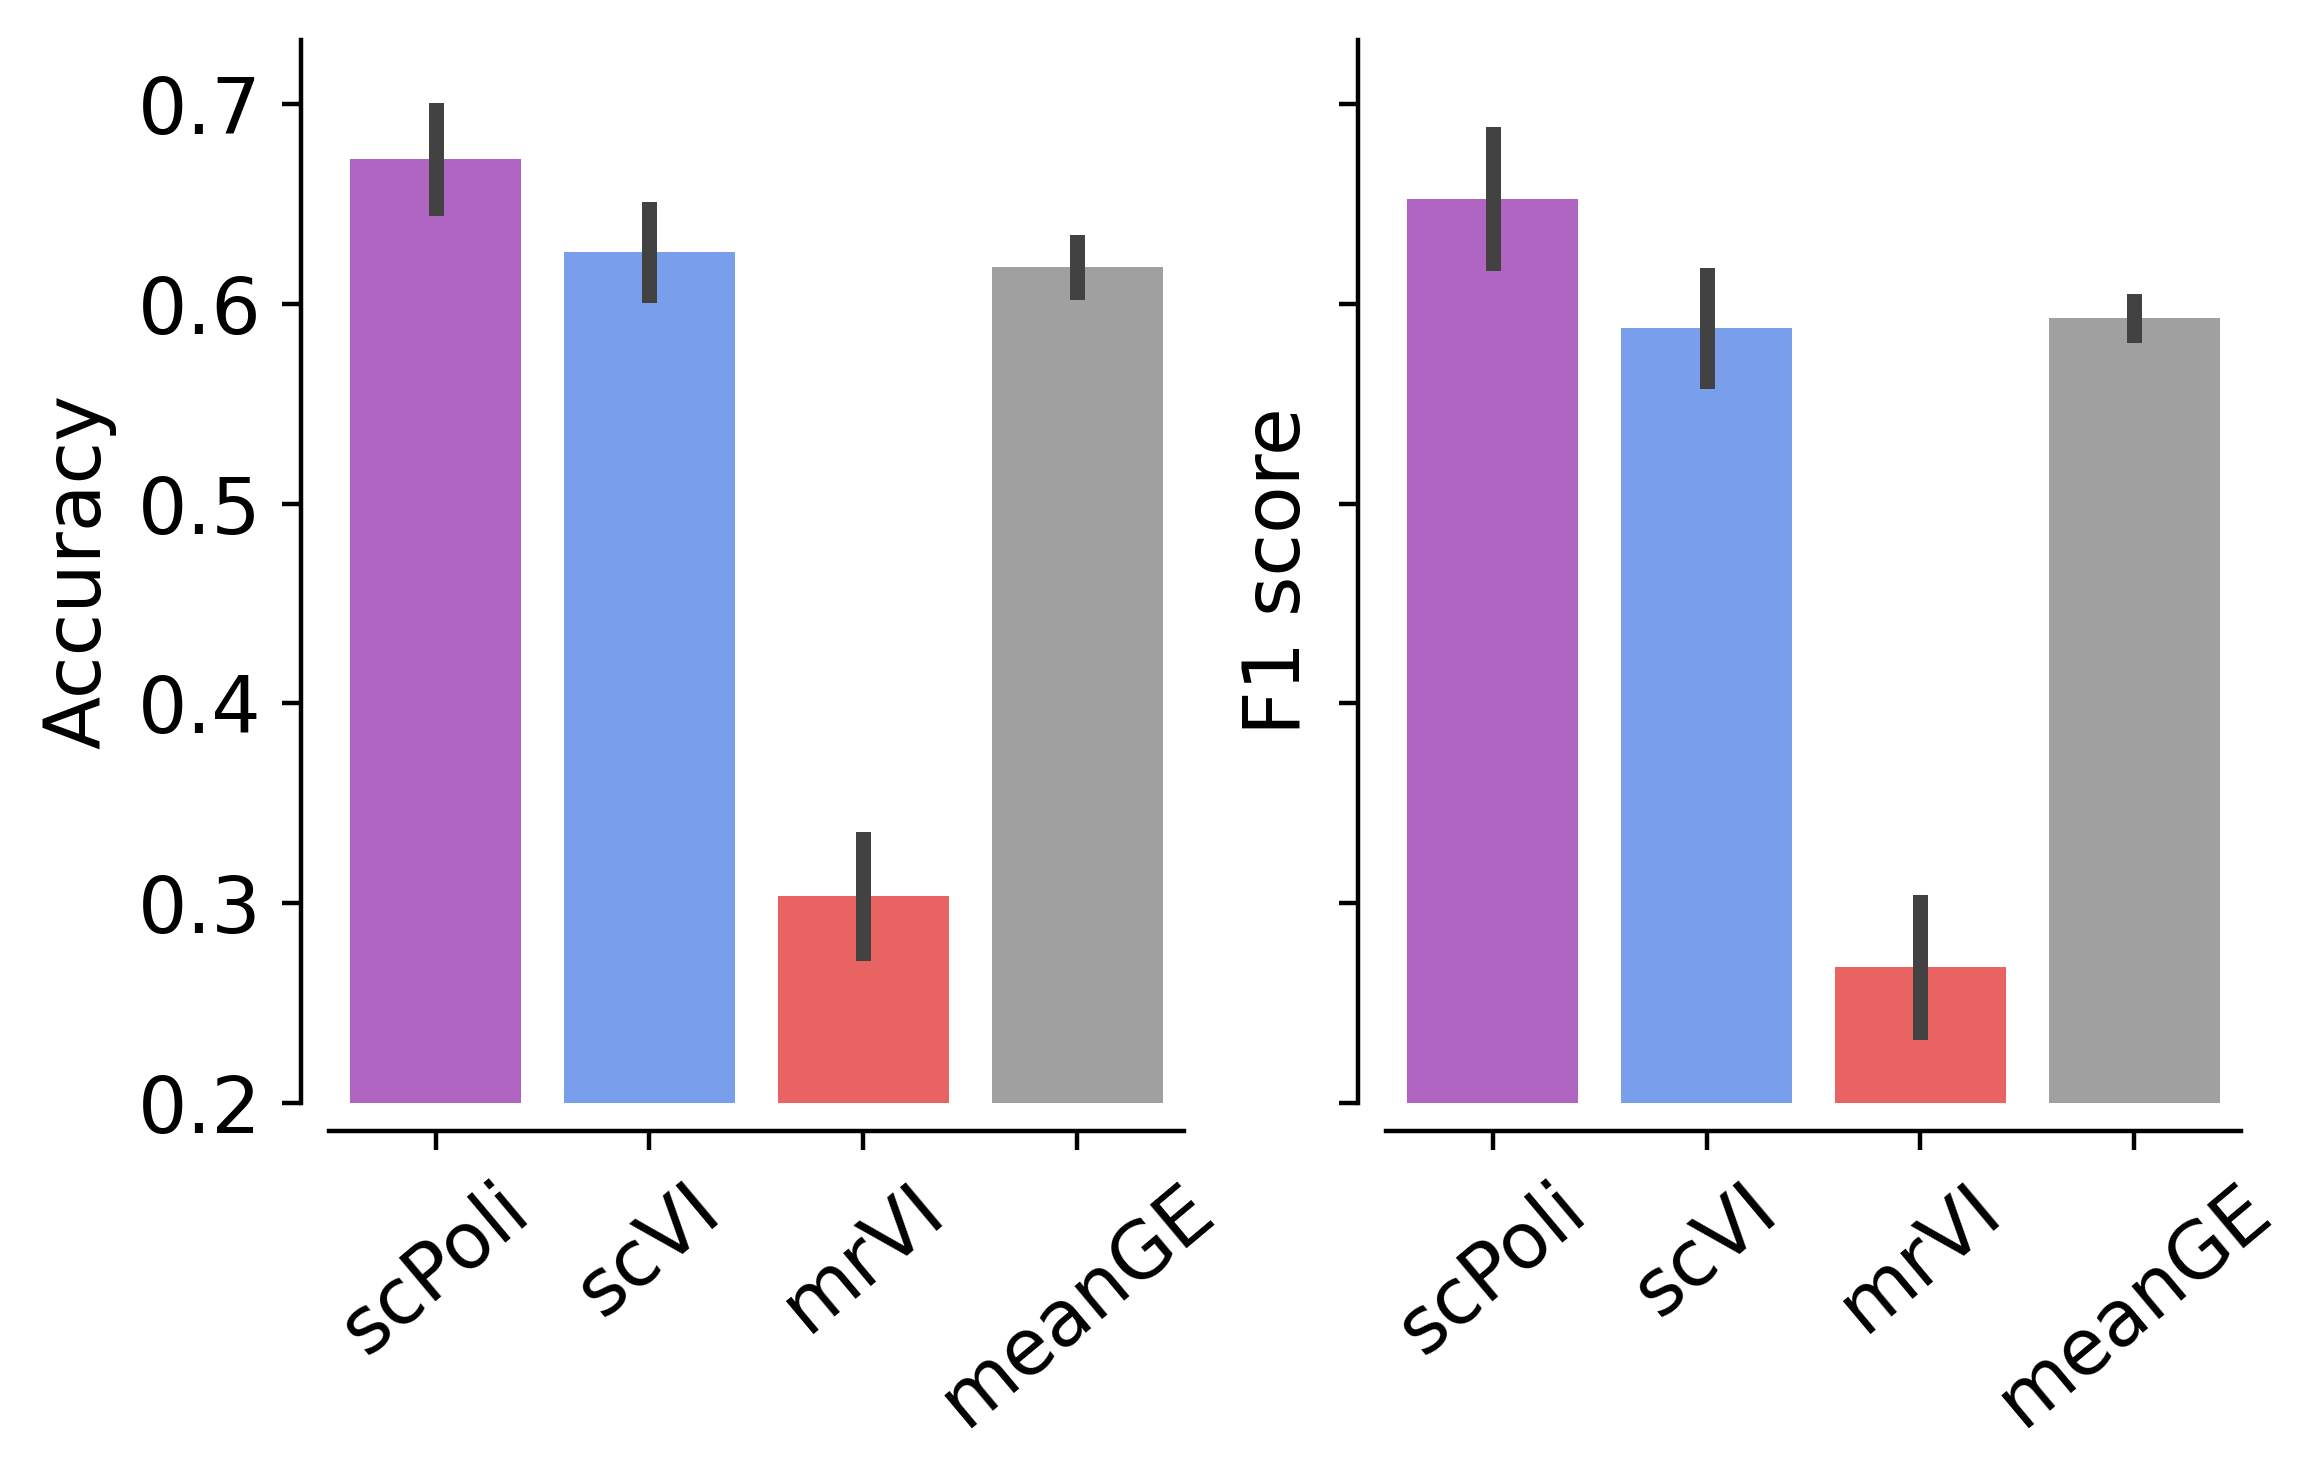

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
sns.barplot(
    x='model', 
    y='accuracy', 
    data=df_full, 
    estimator=np.mean, 
    errorbar='se', 
    ax=ax[0],
    palette=['#BA55D3', '#6699ff', '#ff4d4d', '#A0A0A0'],
)
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[0])
ax[0].set_ylim(bottom=0.2)
l = ax[0].get_xticklabels()
ax[0].grid(False)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('')
ax[0].set_xticklabels(l, rotation=90)
sns.barplot(
    x='model', 
    y='weighted avg', 
    data=df_full, 
    estimator=np.mean, 
    errorbar='se', 
    ax=ax[1],
    palette=['#BA55D3', '#6699ff', '#ff4d4d', '#A0A0A0'],
)
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[1])
l = ax[1].get_xticklabels()
ax[1].set_ylim(bottom=0.2)
ax[1].grid(False)
ax[1].set_ylabel('F1 score')
ax[1].set_xlabel('')
fig.tight_layout()
sns.despine(offset=5)
ax[0].set_xticklabels(l, rotation=40)
ax[1].set_xticklabels(l, rotation=40)
fig.savefig('classification_performance.png', dpi=400, bbox_inches='tight')

In [14]:
import scipy

In [15]:
df_full.groupby('model').agg(scipy.stats.sem)

,mild,moderate,severe,accuracy,macro avg,weighted avg,healthy,nan
model,,,,,,,,
scPoli,0.013134,0.038946,0.076630,0.024725,0.030539,0.032383,NaN,NaN
scVI,0.025289,0.013410,0.071524,0.021437,0.051143,0.026637,NaN,0.155242
meanGE,0.009487,0.011516,0.044722,0.012560,0.019519,0.008653,0.090431,NaN


In [16]:
df_full.groupby('model').std()

,mild,moderate,severe,accuracy,macro avg,weighted avg,healthy,nan
model,,,,,,,,
scPoli,0.029369,0.087087,0.171349,0.055287,0.068288,0.072410,NaN,NaN
scVI,0.056548,0.029986,0.159932,0.047934,0.114360,0.059562,NaN,0.347131
meanGE,0.021212,0.025751,0.100003,0.028085,0.043646,0.019348,0.20221,NaN


In [17]:
df_full.groupby('model').mean()

,mild,moderate,severe,accuracy,macro avg,weighted avg,healthy,nan
model,,,,,,,,
scPoli,0.812894,0.623807,0.347854,0.672441,0.594852,0.652568,NaN,NaN
scVI,0.780728,0.605757,0.266667,0.625926,0.465788,0.587961,NaN,0.21
meanGE,0.814344,0.575621,0.298095,0.618519,0.458682,0.592804,0.146667,NaN


In [18]:
(65.3 - 59.3) / 59.3

0.10118043844856661

In [19]:
(67.2 - 62.3) / 62.3

0.07865168539325852

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=False)
sns.barplot(
    x='model', 
    y='accuracy', 
    data=df_full, 
    estimator=np.mean, 
    errorbar='se', 
    ax=ax[0],) #palette=['#BA55D3', '#A0A0A0'])
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[0])
ax[0].set_ylim(bottom=0.2)
l = ax[0].get_xticklabels()
ax[0].grid(False)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('')
ax[0].set_xticklabels(l, rotation=90)
sns.barplot(
    x='model', 
    y='weighted avg', 
    data=df_full, 
    estimator=np.mean, 
    errorbar='se', 
    ax=ax[1],) #palette=['#BA55D3', '#A0A0A0'])
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[1])
l = ax[1].get_xticklabels()
ax[1].set_ylim(bottom=0.2)
ax[1].grid(False)
ax[1].set_ylabel('F1 score')
ax[1].set_xlabel('')
fig.tight_layout()
sns.despine(offset=5)
ax[0].set_xticklabels(l, rotation=45)
ax[1].set_xticklabels(l, rotation=45)
fig.savefig('classification_performance.png', dpi=400, bbox_inches='tight')

In [31]:
from scipy.stats import ttest_rel, ttest_ind

In [32]:
df_full[df_full['model'] == 'scPoli']['accuracy'].values

array([0.66666667, 0.7037037 , 0.59183673, 0.74      , 0.66      ])

In [33]:
ttest_rel(
    df_full[df_full['model'] == 'scPoli']['accuracy'].values,
    df_full[df_full['model'] == 'meanGE']['accuracy'].values
)

TtestResult(statistic=2.5372878567557597, pvalue=0.0641655298081682, df=4)

In [34]:
ttest_rel(
    df_full[df_full['model'] == 'scPoli']['weighted avg'].values,
    df_full[df_full['model'] == 'scVI']['weighted avg'].values
)

TtestResult(statistic=1.5363419871277988, pvalue=0.19926095978800565, df=4)

In [35]:
ttest_rel(
    df_full[df_full['model'] == 'scPoli']['weighted avg'].values,
    df_full[df_full['model'] == 'mrVI']['weighted avg'].values
)

TtestResult(statistic=31.80544734082157, pvalue=5.824900239160626e-06, df=4)